# 0.0. IMPORTS

In [1]:
import pandas     as pd
import numpy      as np
import psycopg2   as pg
import seaborn    as sns
import scikitplot as skplt


from matplotlib import pyplot          as plt
from sklearn    import preprocessing   as pp
from sklearn    import model_selection as ms
from sklearn    import ensemble        as en
from sklearn    import neighbors       as nh
from sklearn    import linear_model    as lm


import warnings

import pandas.io.sql     as psql

from IPython.core.display  import HTML

## 0.1. Helper Functions

In [2]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [20, 8]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()
    
    
warnings.filterwarnings( 'ignore' )
pd.options.display.float_format = '{:.6f}'.format

In [3]:
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


## 0.2. Loading Data

In [4]:
# Credentials
host =     'comunidade-ds-postgres.c50pcakiuwi3.us-east-1.rds.amazonaws.com'
port =      5432
database = 'comunidadedsdb'
username = 'member'
pwd =      'cdspa'



# Connecting to database
conn = pg.connect(  user=username,
                    password=pwd,
                    host=host,
                    port=port,
                    database=database )



cursor = conn.cursor()

In [5]:
# Query Schemas
query_schema = """
    SELECT nspname
    FROM pg_catalog.pg_namespace
"""

cursor.execute( query_schema )

print(cursor.fetchall())

[('pg_toast',), ('pg_temp_1',), ('pg_toast_temp_1',), ('pg_catalog',), ('information_schema',), ('public',), ('pa004',), ('pg_temp_4',), ('pg_toast_temp_4',), ('pa005',), ('pg_temp_9',), ('pg_toast_temp_9',)]


In [6]:
# Query Tables
query_tables = """
SELECT * FROM pa004.users u LEFT JOIN pa004.vehicle v on (u.id = v.id)
                            LEFT JOIN pa004.insurance i on (u.id = i.id)
        order by u.id
"""

# Defining raw dataset
df_raw_table = pd.read_sql(query_tables, conn)


# Closing cursor and connction
cursor.close()
conn.close()

In [7]:
df_raw_table.head()

,id,gender,age,region_code,policy_sales_channel,id,driving_license,vehicle_age,vehicle_damage,id,previously_insured,annual_premium,vintage,response
0,1,Male,44,28.000000,26.000000,1,1,> 2 Years,Yes,1,0,40454.000000,217,1
1,2,Male,76,3.000000,26.000000,2,1,1-2 Year,No,2,0,33536.000000,183,0
2,3,Male,47,28.000000,26.000000,3,1,> 2 Years,Yes,3,0,38294.000000,27,1
3,4,Male,21,11.000000,152.000000,4,1,< 1 Year,No,4,1,28619.000000,203,0
4,5,Female,29,41.000000,152.000000,5,1,< 1 Year,No,5,1,27496.000000,39,0


# 1.0. Data Description

In [8]:
df1 = df_raw_table.copy()

In [9]:
df1.columns

Index(['id', 'gender', 'age', 'region_code', 'policy_sales_channel', 'id',
       'driving_license', 'vehicle_age', 'vehicle_damage', 'id',
       'previously_insured', 'annual_premium', 'vintage', 'response'],
      dtype='object')

In [10]:
# Removing duplicated columns
df1 = df1.loc[:,~df1.columns.duplicated()]

## 1.1. Data Dimension

In [11]:
print(f"Number of Rows: {df1.shape[0]}")
print(f"Number of Columns: {df1.shape[1]}")

Number of Rows: 381109
Number of Columns: 12


## 1.2. Data Types

In [12]:
df1.dtypes

id                        int64
gender                   object
age                       int64
region_code             float64
policy_sales_channel    float64
driving_license           int64
vehicle_age              object
vehicle_damage           object
previously_insured        int64
annual_premium          float64
vintage                   int64
response                  int64
dtype: object

## 1.3. Check NA

In [13]:
df1.isnull().sum()

id                      0
gender                  0
age                     0
region_code             0
policy_sales_channel    0
driving_license         0
vehicle_age             0
vehicle_damage          0
previously_insured      0
annual_premium          0
vintage                 0
response                0
dtype: int64

## 1.4. Data Descriptive

In [14]:
num_attributes = df1.select_dtypes( include=['int64', 'float64'] )
cat_attributes = df1.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'] )

In [15]:
# Central Tendency - Mean and Median
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

# Dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T
d2 = pd.DataFrame( num_attributes.apply( min ) ).T
d3 = pd.DataFrame( num_attributes.apply( max ) ).T
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T

# Concatenate
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']

In [16]:
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,id,1.000000,381109.000000,381108.000000,190555.000000,190555.000000,110016.691870,0.000000,-1.200000
1,age,20.000000,85.000000,65.000000,38.822584,36.000000,15.511591,0.672539,-0.565655
2,region_code,0.000000,52.000000,52.000000,26.388807,28.000000,13.229871,-0.115266,-0.867857
3,policy_sales_channel,1.000000,163.000000,162.000000,112.034295,133.000000,54.203924,-0.900008,-0.970810
4,driving_license,0.000000,1.000000,1.000000,0.997869,1.000000,0.046109,-21.595182,464.354302
5,previously_insured,0.000000,1.000000,1.000000,0.458210,0.000000,0.498251,0.167747,-1.971871
6,annual_premium,2630.000000,540165.000000,537535.000000,30564.389581,31669.000000,17213.132474,1.766087,34.004569
7,vintage,10.000000,299.000000,289.000000,154.347397,154.000000,83.671194,0.003030,-1.200688
8,response,0.000000,1.000000,1.000000,0.122563,0.000000,0.327935,2.301906,3.298788


# 2.0. Feature Engineering

In [17]:
df2 = df1.copy()

In [18]:
df2.head()

,id,gender,age,region_code,policy_sales_channel,driving_license,vehicle_age,vehicle_damage,previously_insured,annual_premium,vintage,response
0,1,Male,44,28.000000,26.000000,1,> 2 Years,Yes,0,40454.000000,217,1
1,2,Male,76,3.000000,26.000000,1,1-2 Year,No,0,33536.000000,183,0
2,3,Male,47,28.000000,26.000000,1,> 2 Years,Yes,0,38294.000000,27,1
3,4,Male,21,11.000000,152.000000,1,< 1 Year,No,1,28619.000000,203,0
4,5,Female,29,41.000000,152.000000,1,< 1 Year,No,1,27496.000000,39,0


In [19]:
# vehicle age
df2['vehicle_age'] = df2['vehicle_age'].apply( lambda x: 'over_2_years' if x =='> 2 Years' else 'between_1_2_year' if x == '1-2 Year' else 'below_1_year') 

# vehicle damage
df2['vehicle_damage'] = df2['vehicle_damage'].apply( lambda x: 0 if x == "No" else 1 ) 

# 3.0. Data Filtering

In [20]:
df3 = df2.copy()

# 4.0. EDA

In [21]:
df4 = df3.copy()

In [22]:
df4.columns

Index(['id', 'gender', 'age', 'region_code', 'policy_sales_channel',
       'driving_license', 'vehicle_age', 'vehicle_damage',
       'previously_insured', 'annual_premium', 'vintage', 'response'],
      dtype='object')

## 4.1. Univariated Analysis

In [23]:
# Gender
pd.crosstab( df4['gender'], df4['response'] ).apply( lambda x: x / x.sum(), axis = 1)


response,0,1
gender,,
Female,0.896098,0.103902
Male,0.861589,0.138411


In [24]:
aux = df4[['id', 'gender', 'response']].groupby( ['gender', 'response'] ).count().reset_index()
aux

,gender,response,id
0,Female,0,156835
1,Female,1,18185
2,Male,0,177564
3,Male,1,28525


<AxesSubplot:xlabel='age', ylabel='Count'>

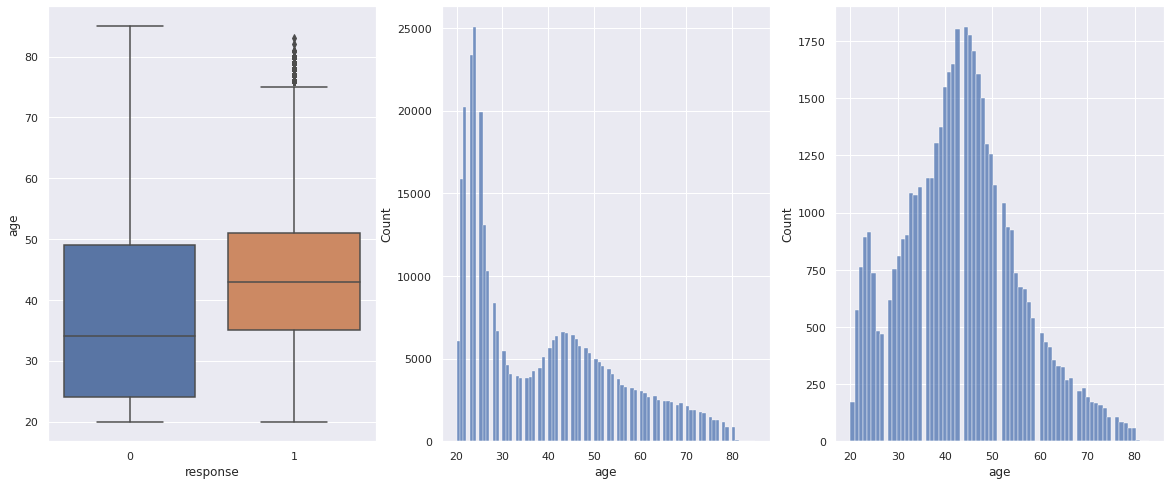

In [25]:
# Age

plt.subplot(1, 3, 1)
sns.boxplot( x='response', y='age', data=df4)

plt.subplot(1, 3, 2)
aux00 = df4.loc[df4['response'] == 0, 'age']
sns.histplot( aux00 )

plt.subplot(1, 3, 3)
aux00 = df4.loc[df4['response'] == 1, 'age']
sns.histplot( aux00 )

<AxesSubplot:xlabel='region_code', ylabel='id'>

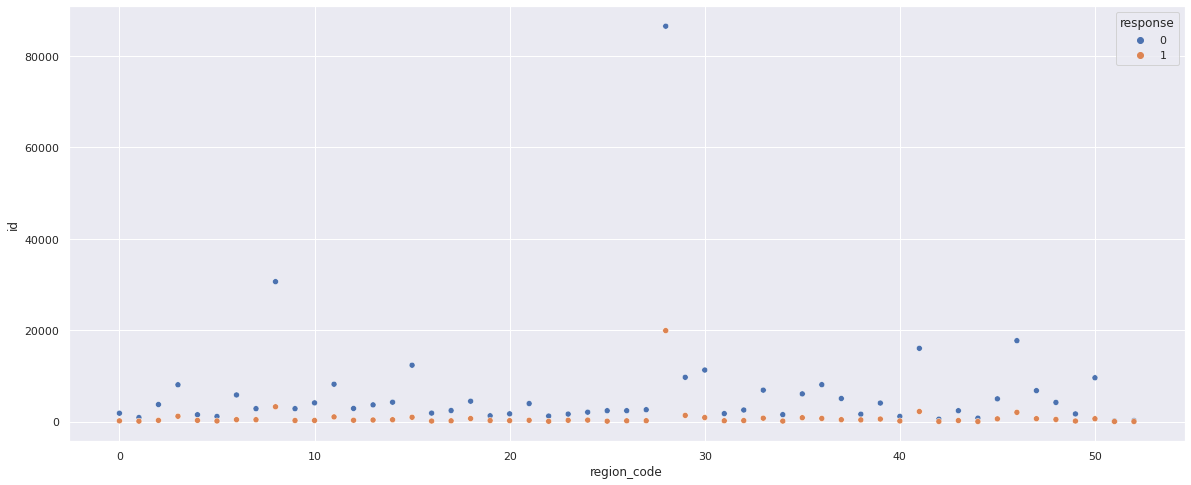

In [26]:
# Region Code
aux = df4[['id', 'region_code', 'response']].groupby( ['region_code', 'response'] ).count().reset_index()
sns.scatterplot( x='region_code', y='id', hue='response', data=aux)

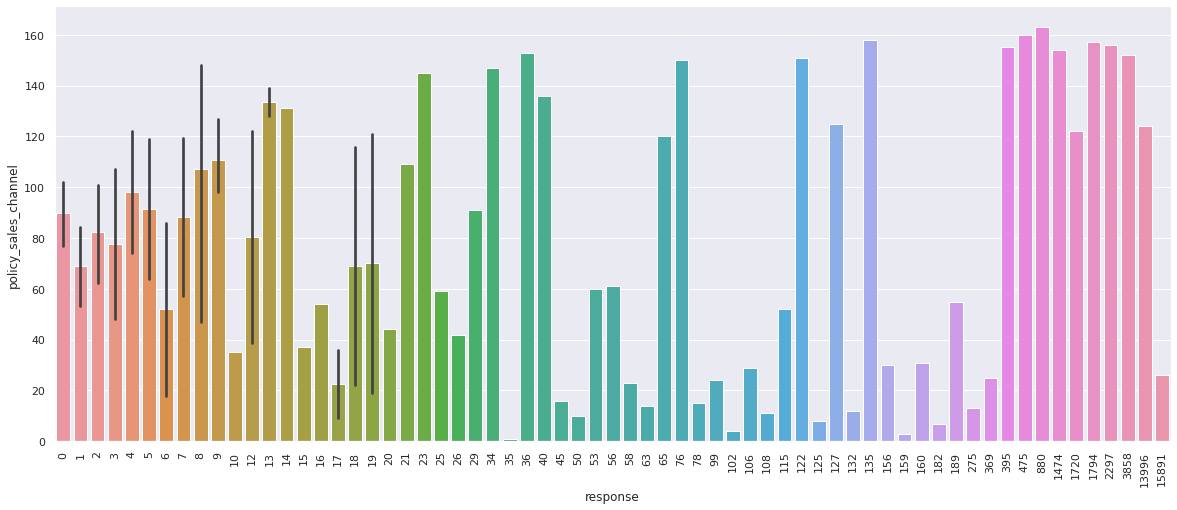

In [27]:
# Policy Sales Channel
aux = df4[['policy_sales_channel', 'response']].groupby( 'policy_sales_channel').sum().reset_index()
sns.barplot( x= 'response', y='policy_sales_channel', data=aux)
plt.xticks( rotation=90 );


# FAZER O GRAFICO DE BARRAS EMPILHADAS COM %  - stacked percentage bar chart python

In [28]:
# Driving License
aux = df4[['response', 'driving_license']].groupby('response').sum().reset_index()

<AxesSubplot:xlabel='response', ylabel='driving_license'>

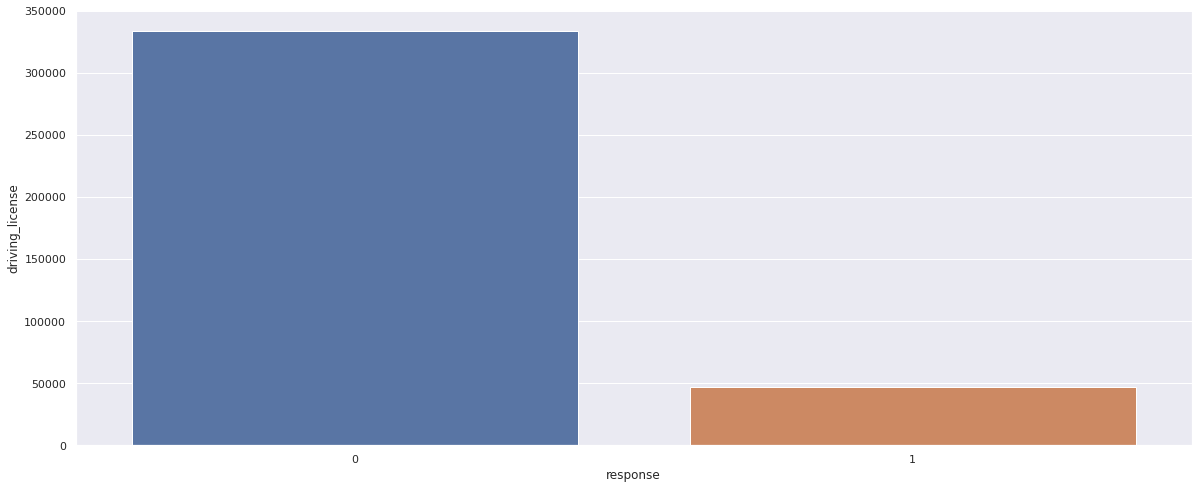

In [29]:
sns.barplot( x='response', y='driving_license', data=aux)

<AxesSubplot:xlabel='vehicle_age', ylabel='id'>

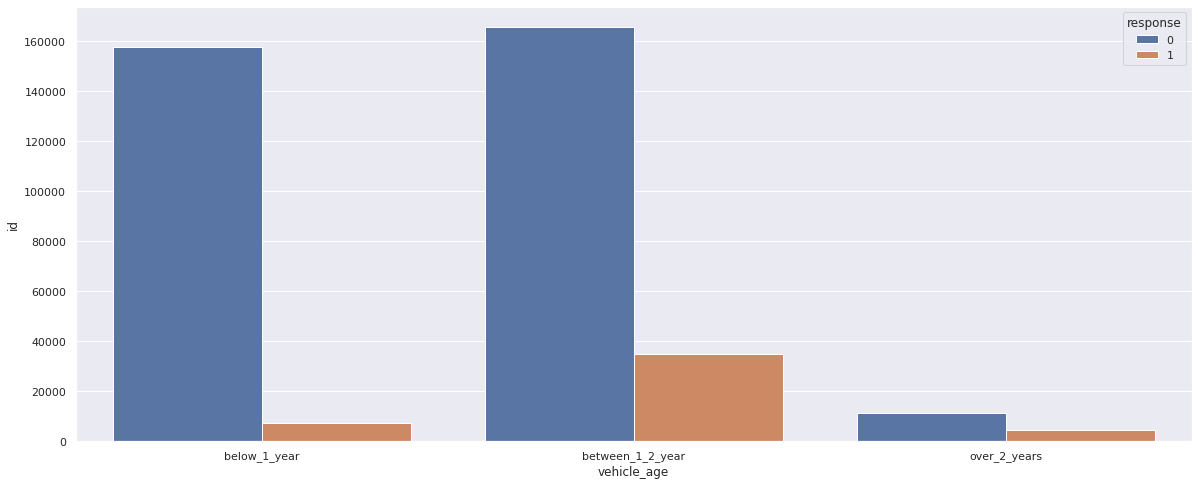

In [30]:
# Vehicle Age
aux = df4[['id','vehicle_age', 'response' ]].groupby(['response', 'vehicle_age']).count().reset_index()
sns.barplot( x='vehicle_age', y='id', hue='response',data=aux)

In [31]:
aux.head()

,response,vehicle_age,id
0,0,below_1_year,157584
1,0,between_1_2_year,165510
2,0,over_2_years,11305
3,1,below_1_year,7202
4,1,between_1_2_year,34806


In [32]:
# Vehicle Damage

In [33]:
# Previously Insured
pd.crosstab( df4['previously_insured'], df4['response'] ).apply( lambda x: x / x.sum(), axis = 1)

response,0,1
previously_insured,,
0,0.774546,0.225454
1,0.999095,0.000905


<AxesSubplot:xlabel='annual_premium', ylabel='Count'>

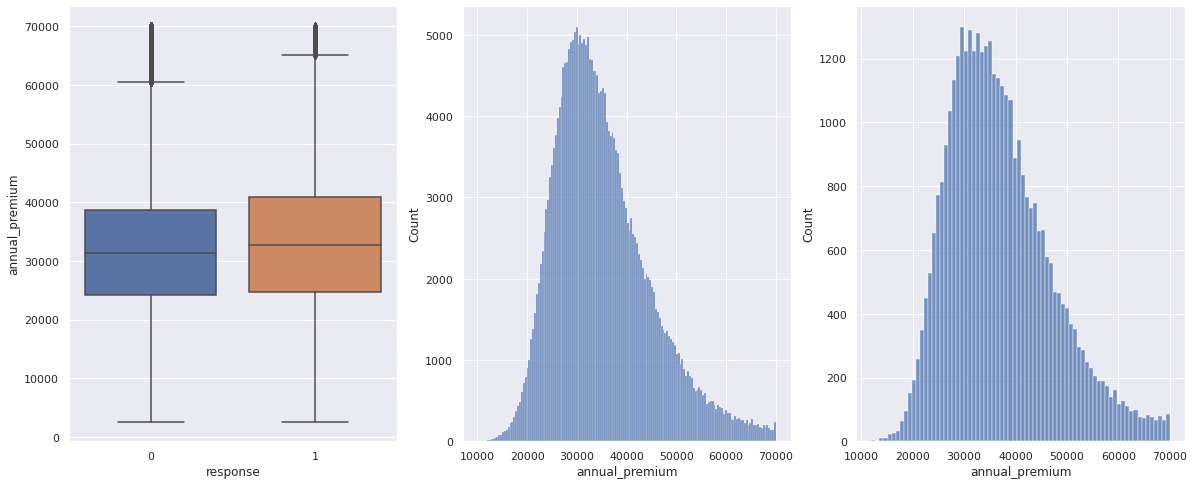

In [34]:
# Annual Premium

plt.subplot(1, 3, 1)
aux = df4.loc[df4['annual_premium'] < 70000]
sns.boxplot( x='response', y='annual_premium', data=aux)


aux = df4.loc[(df4['annual_premium'] > 10000) & (df4['annual_premium'] < 70000)]
plt.subplot(1, 3, 2)
aux00 = aux.loc[aux['response'] == 0, 'annual_premium']
sns.histplot( aux00 )

plt.subplot(1, 3, 3)
aux00 = aux.loc[aux['response'] == 1, 'annual_premium']
sns.histplot( aux00 )

<AxesSubplot:xlabel='vintage', ylabel='Count'>

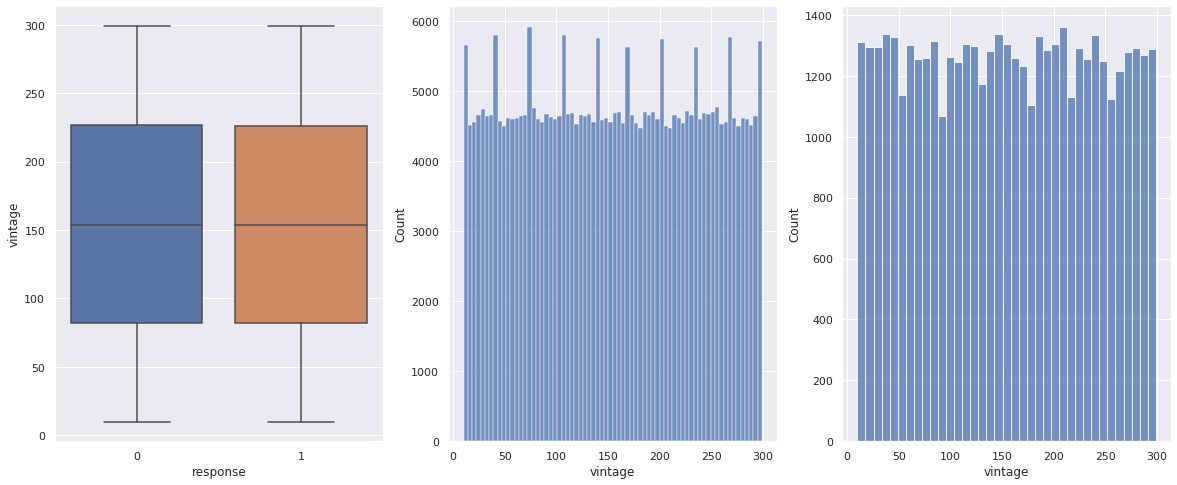

In [35]:
# Vintage

plt.subplot(1, 3, 1)
sns.boxplot( x='response', y='vintage', data=df4)

plt.subplot(1, 3, 2)
aux00 = df4.loc[df4['response'] == 0, 'vintage']
sns.histplot( aux00 )

plt.subplot(1, 3, 3)
aux00 = df4.loc[df4['response'] == 1, 'vintage']
sns.histplot( aux00 )

# 5.0. Data preparation

In [36]:
df5 = df4.copy()

In [37]:
X = df4.drop( 'response', axis=1 )
y = df4['response'].copy()

x_train, x_val, y_train, y_val = ms.train_test_split( X, y, test_size=0.2 )

df5 = pd.concat( [x_train, y_train], axis=1 )

## 5.1. Standardization

In [38]:
ss = pp.StandardScaler()

# Annual Premium
df5['annual_premium'] = ss.fit_transform( df5[['annual_premium']].values )

## 5.2. Rescaling

In [39]:
mms_age = pp.MinMaxScaler()
mms_vintage = pp.MinMaxScaler()

# Age
df5['age'] = mms_age.fit_transform( df5[['age']].values )

# Vintage
df5['vintage'] = mms_vintage.fit_transform( df5[['vintage']].values )

## 5.3. Encoder

### 5.3.1. Target Encoder

In [40]:
# Target Encoder

# Gender
target_encode_gender = df5.groupby('gender')['response'].mean()
df5['gender'] = df5['gender'].map( target_encode_gender )

# Region Code
target_encode_region_code = df5.groupby('region_code')['response'].mean()
df5['region_code'] = df5['region_code'].map(target_encode_region_code)


### 5.3.2. Dummies

In [41]:
# Vehicle Age
df5 = pd.get_dummies( df5, prefix='vehicle_age', columns=['vehicle_age'] )

### 5.3.3. Frequency Encoder

In [42]:
# Policy Sales Channel
fe_policy_sales_channel = df5.groupby( 'policy_sales_channel' ).size() / len(df5)
df5['policy_sales_channel'] = df5['policy_sales_channel'].map(fe_policy_sales_channel)

## 5.4. Enconding Validation Data

In [43]:
# Annual Premium
x_val['annual_premium'] = ss.fit_transform( x_val[['annual_premium']].values )

# Age
x_val['age'] = mms_age.fit_transform( x_val[['age']].values )

# Vintage
x_val['vintage'] = mms_vintage.fit_transform( x_val[['vintage']].values )

# Gender
x_val['gender'] = x_val['gender'].map( target_encode_gender )

# Region Code
x_val['region_code'] = x_val['region_code'].map( target_encode_region_code)

# Vehicle Age
x_val = pd.get_dummies( x_val, prefix='vehicle_age', columns=['vehicle_age'] )

# Policy Sales Channel
x_val['policy_sales_channel'] = x_val['policy_sales_channel'].map(fe_policy_sales_channel)

# Fillna
x_val = x_val.fillna( 0 )

# 6.0. Feature Selection

## 6.1. Feature Importancy

In [44]:
# model_definition
forest = en.RandomForestClassifier( n_estimators=250, random_state=0, n_jobs=-1 )

# Data Preparation
x_train_n = df5.drop( ['id', 'response'], axis=1 )
y_train_n = y_train.values
forest.fit( x_train_n, y_train_n )

RandomForestClassifier(n_estimators=250, n_jobs=-1, random_state=0)

Feature Ranking:
                        feature  importance
0                       vintage    0.281093
0                annual_premium    0.252908
0                           age    0.147616
0                   region_code    0.096700
0                vehicle_damage    0.072802
0          policy_sales_channel    0.070406
0            previously_insured    0.048624
0      vehicle_age_below_1_year    0.012956
0                        gender    0.009581
0  vehicle_age_between_1_2_year    0.004744
0      vehicle_age_over_2_years    0.002053
0               driving_license    0.000518


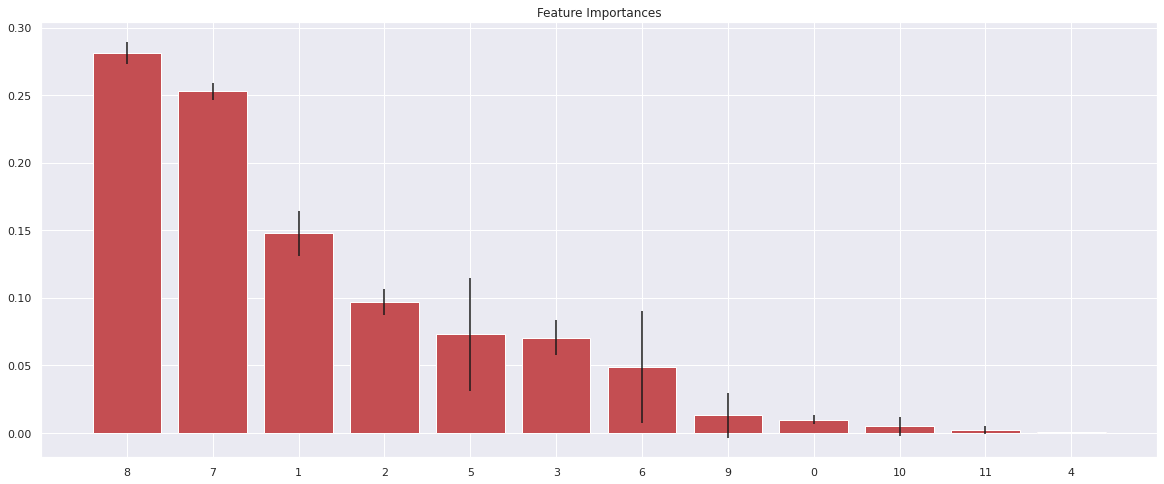

In [45]:
importances = forest.feature_importances_
std = np.std( [tree.feature_importances_ for tree in forest.estimators_], axis=0 )
indices = np.argsort( importances )[::-1]

# Print the feature ranking
print("Feature Ranking:")
df = pd.DataFrame()
for i, j in zip( x_train_n, forest.feature_importances_ ):
    aux = pd.DataFrame( {'feature': i, 'importance': j}, index=[0])
    df = pd.concat( [df, aux], axis=0 )
    
print( df.sort_values( 'importance', ascending=False ) )

# Plot
plt.figure()
plt.title("Feature Importances")
plt.bar(range(x_train_n.shape[1]), importances[indices], color="r", yerr=std[indices], align="center" )
plt.xticks(range(x_train_n.shape[1]), indices )
plt.xlim([-1, x_train_n.shape[1]])
plt.show()


# 7.0. Machine Learning Model

In [46]:
cols_selected = ['vintage', 'annual_premium', 'age', 'region_code', 'vehicle_damage', 'policy_sales_channel', 'previously_insured']

x_train = df5[cols_selected]
x_val = x_val[cols_selected]

## 7.1. KNN

In [47]:
# Model Definition
knn_model = nh.KNeighborsClassifier( n_neighbors=6 )

# Model Training
knn_model.fit( x_train, y_train )

# Model Prediction - Poder de Generalização
yhat_knn = knn_model.predict_proba( x_val )

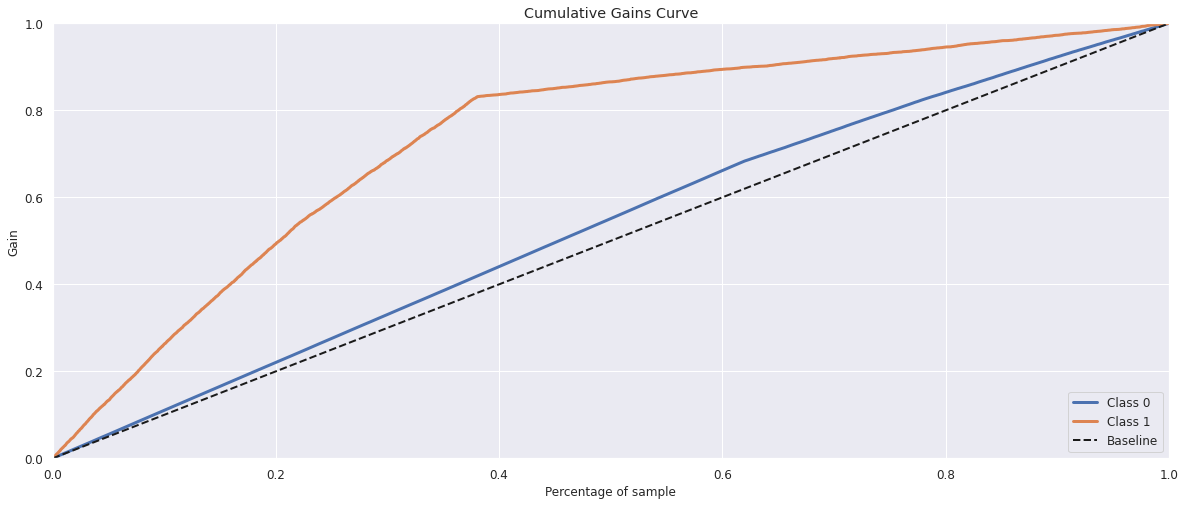

In [48]:
# Accumulative Gain
skplt.metrics.plot_cumulative_gain( y_val, yhat_knn );